In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from scipy import stats
from tqdm import tqdm

from procyon.data.data_utils import DATA_DIR
from procyon.data.inference_utils import (
    create_input_retrieval,
    get_proteins_from_embedding,
    UNIPROT_IDS,
)
from procyon.evaluate.framework.utils import move_inputs_to_device
from procyon.model.model_unified import UnifiedProCyon

[2025-03-06 13:41:43,670] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In this notebook, we show how ProCyon models are able to succesfully retrieve proteins associated with a given disease, even when that gene-disease association comes from varying sources of evidence.

This is the data shown in Figure 3c of our manuscript.

# Protein Retrieval using as ground truth sets of genes identified through different sources - provided by OpenTargets dataset

In [3]:
# Whether to generate new ProCyon scores or use saved scores from ProCyon-Instruct
regenerate_scores = False

# Note that running with ProtST requires installing an environment compatible
# with the ProtST model (see README on the `protst_benchmarking` branch).
regenerate_protst = False

# Load pre-trained model

In [4]:
# Replace with the path where you downloaded a pre-trained ProCyon model (e.g. ProCyon-Full)
checkpoint_path = "~/storage/Lab/PLM/huggingface_repos/ProCyon-Split"
CKPT_NAME = os.path.expanduser(checkpoint_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

In [6]:
if regenerate_scores:
    model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME)

    model.bfloat16() # Quantize the model to a smaller precision
    model.eval()
    model.to(device)

In [7]:
# Load saved embeddings for this model
all_protein_embeddings, all_protein_ids = torch.load(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"))
print(all_protein_embeddings.shape)

torch.Size([18174, 2560])


In [8]:

if regenerate_protst:
    from procyon.evaluate.framework.args import EvalArgs
    from procyon.evaluate.framework.protst import ProtSTRetrievalEval

    protst_model = ProtSTRetrievalEval(
        model_config={},
        eval_args=EvalArgs(retrieval_use_cached_target_embeddings=True, batch_size=16),
        model_args=None,
        device=device,
    )

    # Load saved embeddings for this model:
    protst_protein_embeddings, protst_protein_ids = torch.load(os.path.join(
        protst_model.checkpoint_dir,
        "protein_target_embeddings.pkl",
    ))
    # Confirm with size:
    print(protst_protein_embeddings.shape)
    assert np.all(np.array(protst_protein_ids) == np.sort(np.array(protst_protein_ids)))
    assert np.all(np.sort(np.array(protst_protein_ids)) == np.sort(np.array(all_protein_ids)))

# Retrieve omim descriptions for diseases of interest and GT from OpenTargets

In [9]:
data_path = os.path.join(
    DATA_DIR,
    "experimental_data",
    "protein_retrieval_multiple_sources",
)

descr = pd.read_csv(os.path.join(
    data_path,
    "omim_descriptions.csv",
))

with open(os.path.join(
    data_path,
    "gt_dict_thresh_multiple_types_flex_thresholds.pkl",
), 'rb') as f:
    gt_dict = pickle.load(f)

In [10]:
gt_dict["OpenTargets"]["known_drug"]["EFO_0000239"]

['ADRA2B', 'ADRA2A', 'ADRA2C', 'ADRA1B', 'ADRA1A', 'SLC6A2', 'ADRA1D']

# Protein retrieval using OMIM descriptions as input and OpenTargets gene - disease associations as GT

Note that the following cell can take ~1 hour to run due to the large number of model queries. For this reason, we've made the cached scores availabie within ProCyon-Instruct, but feel free to set `regenerate_scores` to True if you'd like to rerun from scratch.

In [11]:
if regenerate_scores:
    types = list(gt_dict["OpenTargets"].keys())

    scores_external = defaultdict(dict)

    for i, efo_subset in enumerate(tqdm(descr.efo)):
        # Skip EFO IDs that don't have any disease associated with them across any type
        found_types = []
        for t in types:
            if efo_subset in gt_dict["OpenTargets"][t] and \
            len(gt_dict["OpenTargets"][t][efo_subset]) > 0 and \
            UNIPROT_IDS.name.isin(gt_dict["OpenTargets"][t][efo_subset]).sum() != 0:
                found_types.append(t)

        if len(found_types) == 0:
            continue

        input_desc = descr[descr.efo == efo_subset].omim_def_curated.item()
        input_simple = create_input_retrieval(
            input_description=input_desc,
            data_args=data_args,
            task_definition=None,
            instruction_source_dataset="disgenet",
            instruction_source_relation="all",
            aaseq_type="protein",
            icl_example_number=1,
        )
        input_simple = move_inputs_to_device(input_simple, device=device)

        with torch.no_grad():
            model_out = model(
                inputs=input_simple,
                retrieval=True,
                aaseq_type="protein",
            )
        df = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        )

        for t in found_types:
            scores_external[t][efo_subset] = np.median(
                stats.percentileofscore(
                    df["sim_score"],
                    df["sim_score"].loc[
                        (df["name"].isin(gt_dict["OpenTargets"][t][efo_subset]))
                    ],
                )
            )

    df_external = (
        pd.DataFrame.from_dict(scores_external)
        .rename_axis(index="efo")
        .reset_index()
    )
    (
        df_external
        .to_csv(os.path.join(
            data_path,
            "validation_gt_different_sources.csv",
        ), index=False)
    )
else:
    df_external = pd.read_csv(
        os.path.join(
            data_path,
            "validation_gt_different_sources.csv",
        )
    )

In [12]:
if regenerate_protst:
    types = list(gt_dict["OpenTargets"].keys())

    scores_external = defaultdict(dict)

    for i, efo_subset in enumerate(tqdm(descr.efo)):
        # Skip EFO IDs that don't have any disease associated with them across any type
        found_types = []
        for t in types:
            if efo_subset in gt_dict["OpenTargets"][t] and \
            len(gt_dict["OpenTargets"][t][efo_subset]) > 0 and \
            UNIPROT_IDS.name.isin(gt_dict["OpenTargets"][t][efo_subset]).sum() != 0:
                found_types.append(t)

        if len(found_types) == 0:
            continue

        input_desc = descr[descr.efo == efo_subset].omim_def_curated.item()
        text_embed = protst_model._get_text_embedding([input_desc])
        df = get_proteins_from_embedding(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embed,
            top_k=None,
        )

        for t in found_types:
            scores_external[t][efo_subset] = np.median(
                stats.percentileofscore(
                    df["sim_score"],
                    df["sim_score"].loc[
                        (df["name"].isin(gt_dict["OpenTargets"][t][efo_subset]))
                    ],
                )
            )

    protst_df = (
        pd.DataFrame.from_dict(scores_external)
        .rename_axis(index="efo")
        .reset_index()
    )
    (
        protst_df
        .to_csv(os.path.join(
            data_path,
            "protst_validation_gt_different_sources.csv",
        ), index=False)
    )
else:
    protst_df = pd.read_csv(
        os.path.join(
            data_path,
            "protst_validation_gt_different_sources.csv",
        )
    )

/tmp/ipykernel_334466/1158402483.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  catplot = sns.swarmplot(
/n/home08/rcalef/sandbox/repos/for_protst/ProCyon/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/home08/rcalef/sandbox/repos/for_protst/ProCyon/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_334466/1158402483.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = catplot.set_xticklabels(
/n/home08/rcalef/sand

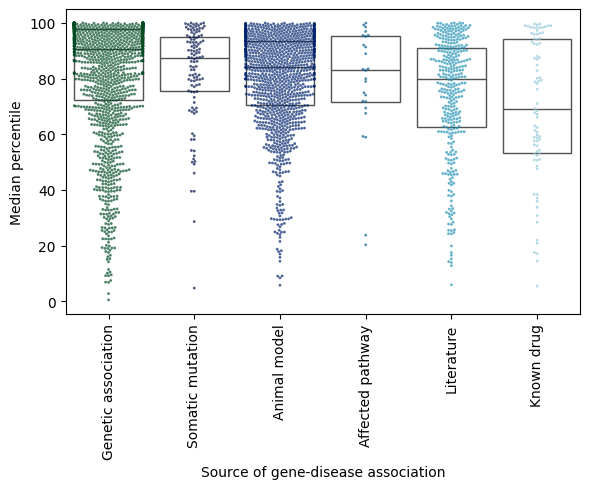

In [13]:
df = (
    pd.melt(df_external, id_vars="efo", var_name="type")
    .loc[lambda x: ~x.value.isna()]
    .assign(
        type=lambda x: x.type.map({
                "animal_model": "Animal model",
                "genetic_association": "Genetic association",
                "somatic_mutation": "Somatic mutation",
                "affected_pathway": "Affected pathway",
                "literature": "Literature",
                "known_drug": "Known drug",
        })
    )
)

plt.figure(figsize=(6, 5))
catplot = sns.swarmplot(
    df,
    x="type",
    y="value",
    palette="ocean",
    order=[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ],
    size=2,
    alpha=0.7,
)
_ = catplot.set_xticklabels(
    labels=[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ],
    rotation=90,
)
catplot = sns.boxplot(
    x="type",
    y="value",
    data=df,
    showcaps=False,
    boxprops={"facecolor": "None"},
    showfliers=False,
    whiskerprops={"linewidth": 0},
)
plt.ylabel("Median percentile")
plt.xlabel("Source of gene-disease association")
plt.tight_layout()

/tmp/ipykernel_334466/3493050485.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  catplot = sns.swarmplot(
/n/home08/rcalef/sandbox/repos/for_protst/ProCyon/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_334466/3493050485.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = catplot.set_xticklabels(
/n/home08/rcalef/sandbox/repos/for_protst/ProCyon/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


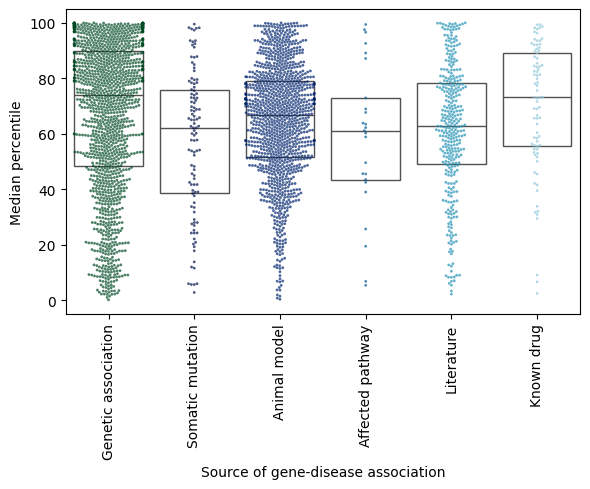

In [14]:
df = (
    pd.melt(protst_df, id_vars="efo", var_name="type")
    .loc[lambda x: ~x.value.isna()]
    .assign(
        type=lambda x: x.type.map({
                "animal_model": "Animal model",
                "genetic_association": "Genetic association",
                "somatic_mutation": "Somatic mutation",
                "affected_pathway": "Affected pathway",
                "literature": "Literature",
                "known_drug": "Known drug",
        })
    )
)

plt.figure(figsize=(6, 5))
catplot = sns.swarmplot(
    df,
    x="type",
    y="value",
    palette="ocean",
    order=[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ],
    size=2,
    alpha=0.7,
)
_ = catplot.set_xticklabels(
    labels=[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ],
    rotation=90,
)
catplot = sns.boxplot(
    x="type",
    y="value",
    data=df,
    showcaps=False,
    boxprops={"facecolor": "None"},
    showfliers=False,
    whiskerprops={"linewidth": 0},
)
plt.ylabel("Median percentile")
plt.xlabel("Source of gene-disease association")
plt.tight_layout()

/tmp/ipykernel_334466/2358441166.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = catplot.set_xticklabels(


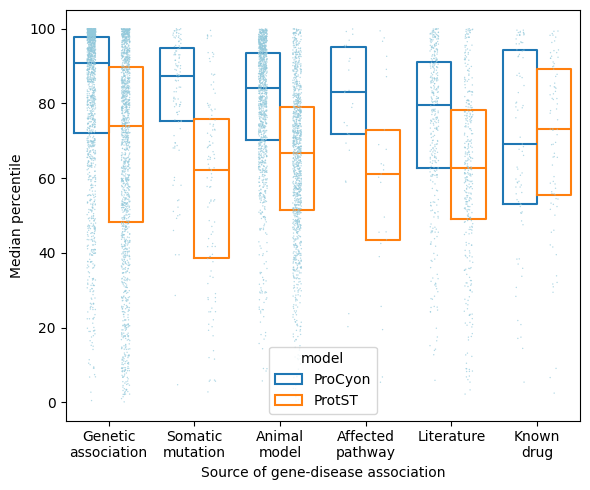

In [20]:
joint_df = (
    pd.concat((
        pd.melt(df_external, id_vars="efo", var_name="type").assign(model="ProCyon"),
        pd.melt(protst_df, id_vars="efo", var_name="type").assign(model="ProtST"),
    ), ignore_index=True)
    .loc[lambda x: ~x.value.isna()]
    .assign(
        type=lambda x: x.type.map({
                "animal_model": "Animal model",
                "genetic_association": "Genetic association",
                "somatic_mutation": "Somatic mutation",
                "affected_pathway": "Affected pathway",
                "literature": "Literature",
                "known_drug": "Known drug",
        })
    )
)

order=[
    "Genetic association",
    "Somatic mutation",
    "Animal model",
    "Affected pathway",
    "Literature",
    "Known drug",
]
assoc_color = {assoc: color for (assoc, color) in zip(order, sns.color_palette("ocean"))}
palette = {model: assoc_color[category] for category in assoc_color for model in joint_df["model"].unique()}


plt.figure(figsize=(6, 5))
catplot = sns.stripplot(
    joint_df,
    x="type",
    y="value",
    hue="model",
    palette=palette,
    dodge=True,
    order=order,
    size=1,
    alpha=0.7,
    legend=False,
)
_ = catplot.set_xticklabels(
    labels=map(lambda x: x.replace(" ", "\n"),[
        "Genetic association",
        "Somatic mutation",
        "Animal model",
        "Affected pathway",
        "Literature",
        "Known drug",
    ]),
    rotation=0,
)
catplot = sns.boxplot(
    x="type",
    y="value",
    hue="model",
    data=joint_df,
    showcaps=False,
    fill=False,
    showfliers=False,
    whiskerprops={"linewidth": 0},
)
plt.ylabel("Median percentile")
plt.xlabel("Source of gene-disease association")
plt.tight_layout()